In [2]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error  #均方误差
from sklearn.metrics import mean_absolute_error  #平方绝对误差
from sklearn.metrics import r2_score  #R square
import warnings

warnings.filterwarnings("ignore")
import seaborn as sns

plt.style.use('ggplot')

In [3]:
df = pd.read_excel("game.xlsx")

In [6]:
def evaluate_model(y, y_pred):
    """通用函数，用于检验显著性"""
    n = len(y)
    MSE = mean_squared_error(y, y_pred)
    RMSE = np.sqrt(mean_squared_error(y, y_pred))
    MAE = mean_absolute_error(y, y_pred)
    R2 = r2_score(y, y_pred)
    Adjusted_R2 = 1 - ((1 - r2_score(y, y_pred)) * (n - 1)) / (n - p - 1)
    print(f"MSE:{MSE},RMSE:{RMSE},MAE:{MAE},R2:{R2}")


def calculate_T(p, q):
    # 计算拐点
    T = math.log(q / p) / (p + q)
    T1 = math.log((2 - 3 ** 0.5) * (q / p)) / (q + p)
    T2 = math.log((2 + 3 ** 0.5) * (q / p)) / (q + p)
    ratio = q / p
    print(f"T:{T}, T1:{T1}, T2:{T2}, q/p:{ratio}")

## OLS

Text(0.5, 1.0, 'OLS拟合曲线-新增家庭持有数')

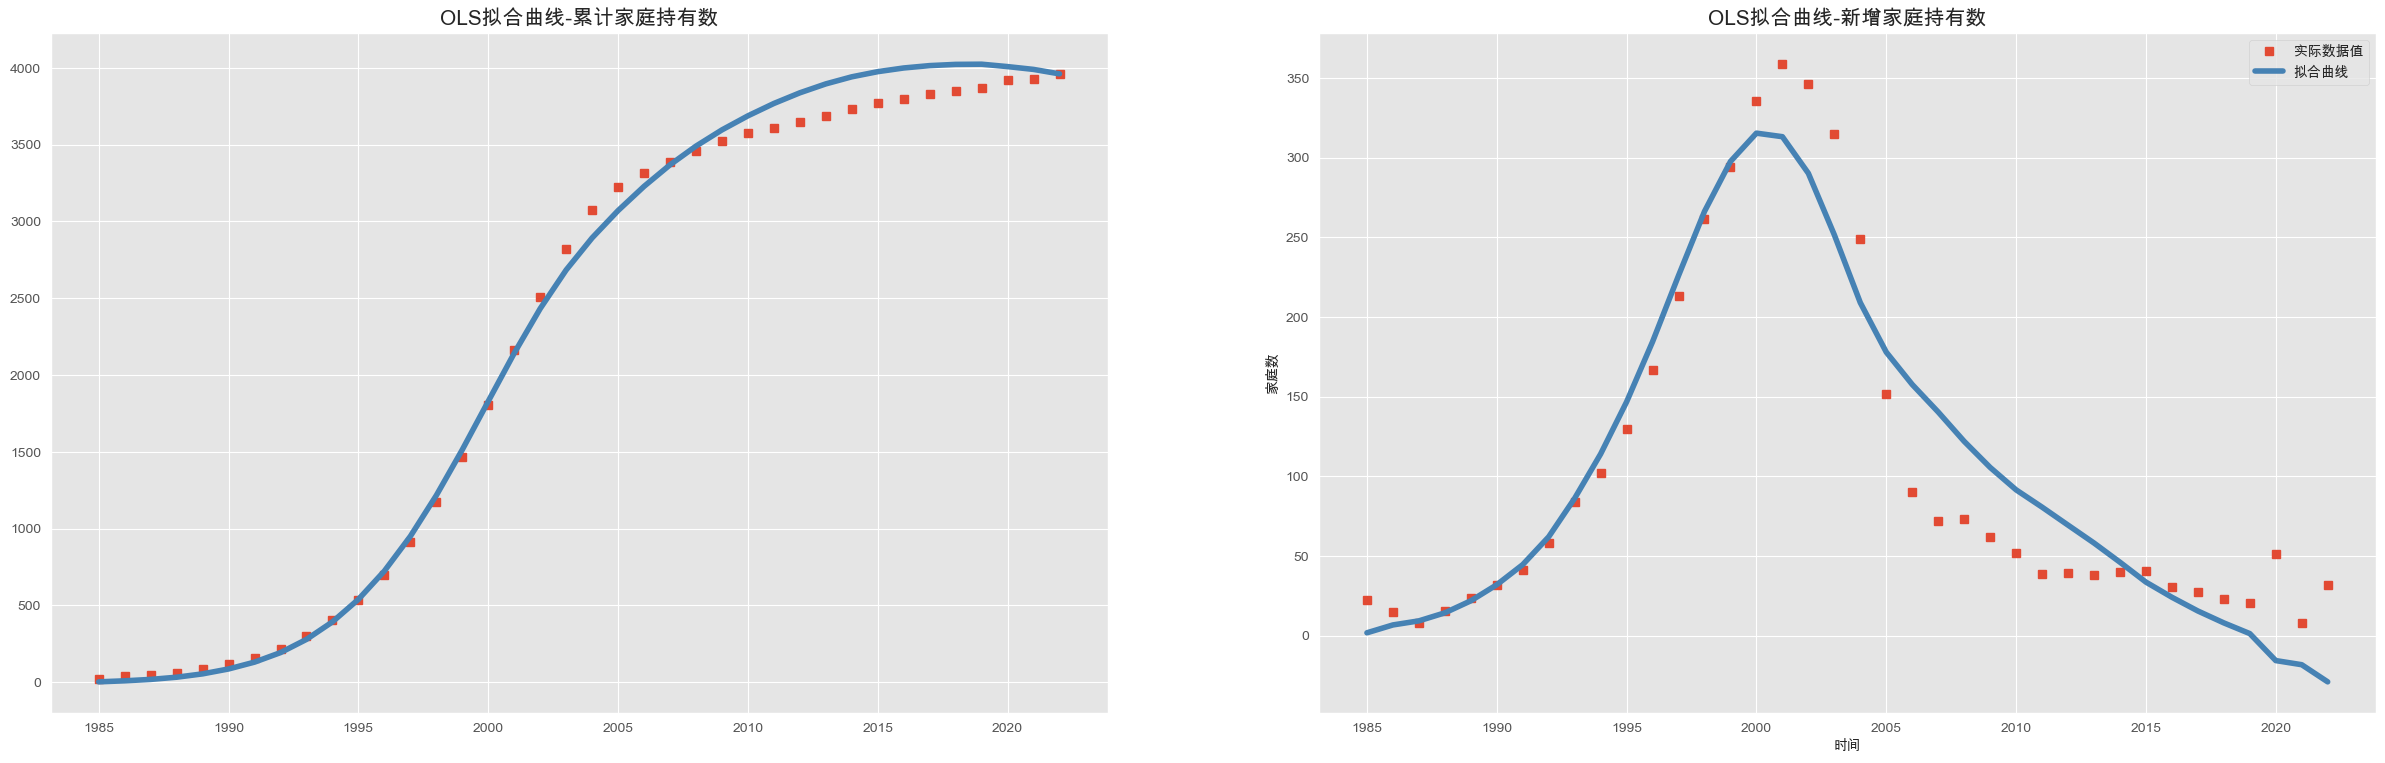

In [16]:
t = np.array([i for i in range(0, 38)])
y = df["y"]
Y = df["Y"]

def line(x, a, b, c):
    return a + b * x + c * x ** 2

popt1, pcov1 = curve_fit(line, Y, y)
a1 = popt1[0]
b1 = popt1[1]
c1 = popt1[2]
m = 2 * a1 / (-b1 + (b1 ** 2 - 4 * a1 * c1) ** 0.5)
p = (-b1 + (b1 ** 2 - 4 * a1 * c1) ** 0.5) / 2
q = (b1 + (b1 ** 2 - 4 * a1 * c1) ** 0.5) / 2

# print(m, p, q)
# calculate_T(p, q)

y_predicted_OLS = line(Y, a1, b1, c1)
Y_predicted_OLS = np.cumsum(y_predicted_OLS)
# evaluate_model(Y, Y_predicted_OLS)

fig = plt.figure(figsize=(30, 30))
plt.rcParams["font.family"] = "Arial Unicode MS"
plt.rcParams["axes.unicode_minus"] = False

plt.subplot(3, 2, 1)
plot1 = plt.plot(t + 1985, Y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, Y_predicted_OLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("OLS拟合曲线-累计家庭持有数", fontsize=15)
plt.subplot(3, 2, 2)
plot1 = plt.plot(t + 1985, y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, y_predicted_OLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.xlabel("时间")
plt.ylabel("家庭数")
plt.legend(loc="best")
plt.title("OLS拟合曲线-新增家庭持有数", fontsize=15)

In [17]:
def draw_pictures(y, y_pred, Y, Y_pred):
    sns.set(font='Times New Roman', font_scale=1)
    sns.set_style("darkgrid")
    sns.set_style(  #设置matplotlib参数
        {"xtick.major.size": 2030,
         "ytick.major.size": 4200})
    sns.scatterplot(x=t + 1985, y=y, color="pink", marker='o', label="real_data")
    sns.lineplot(x=t + 1985, y=y_pred, alpha=0.8, label='curve_fit')
    # g = (g.set_axis_labels("Year","Households Possession of  Game Console") .set(xlim=(0,10),ylim=(0,100)))
    plt.ylabel("New Households Possessing Game Console")  # 调整y轴标签
    plt.xlabel("Year")  # 调整x轴的标签
    fig.set_figwidth(100)  #这个是设置整个图（画布）的大小

    sns.scatterplot(x=t + 1985, y=Y, color="pink", marker='o', label="real_data")
    sns.lineplot(x=t + 1985, y=Y_pred, alpha=0.8, label='curve_fit')
    # g = (g.set_axis_labels("Year","Households Possession of  Game Console") .set(xlim=(0,10),ylim=(0,100)))
    plt.ylabel("Total Households Possessing Game Console")  # 调整y轴标签
    plt.xlabel("Year")  # 调整x轴的标签

## NLS

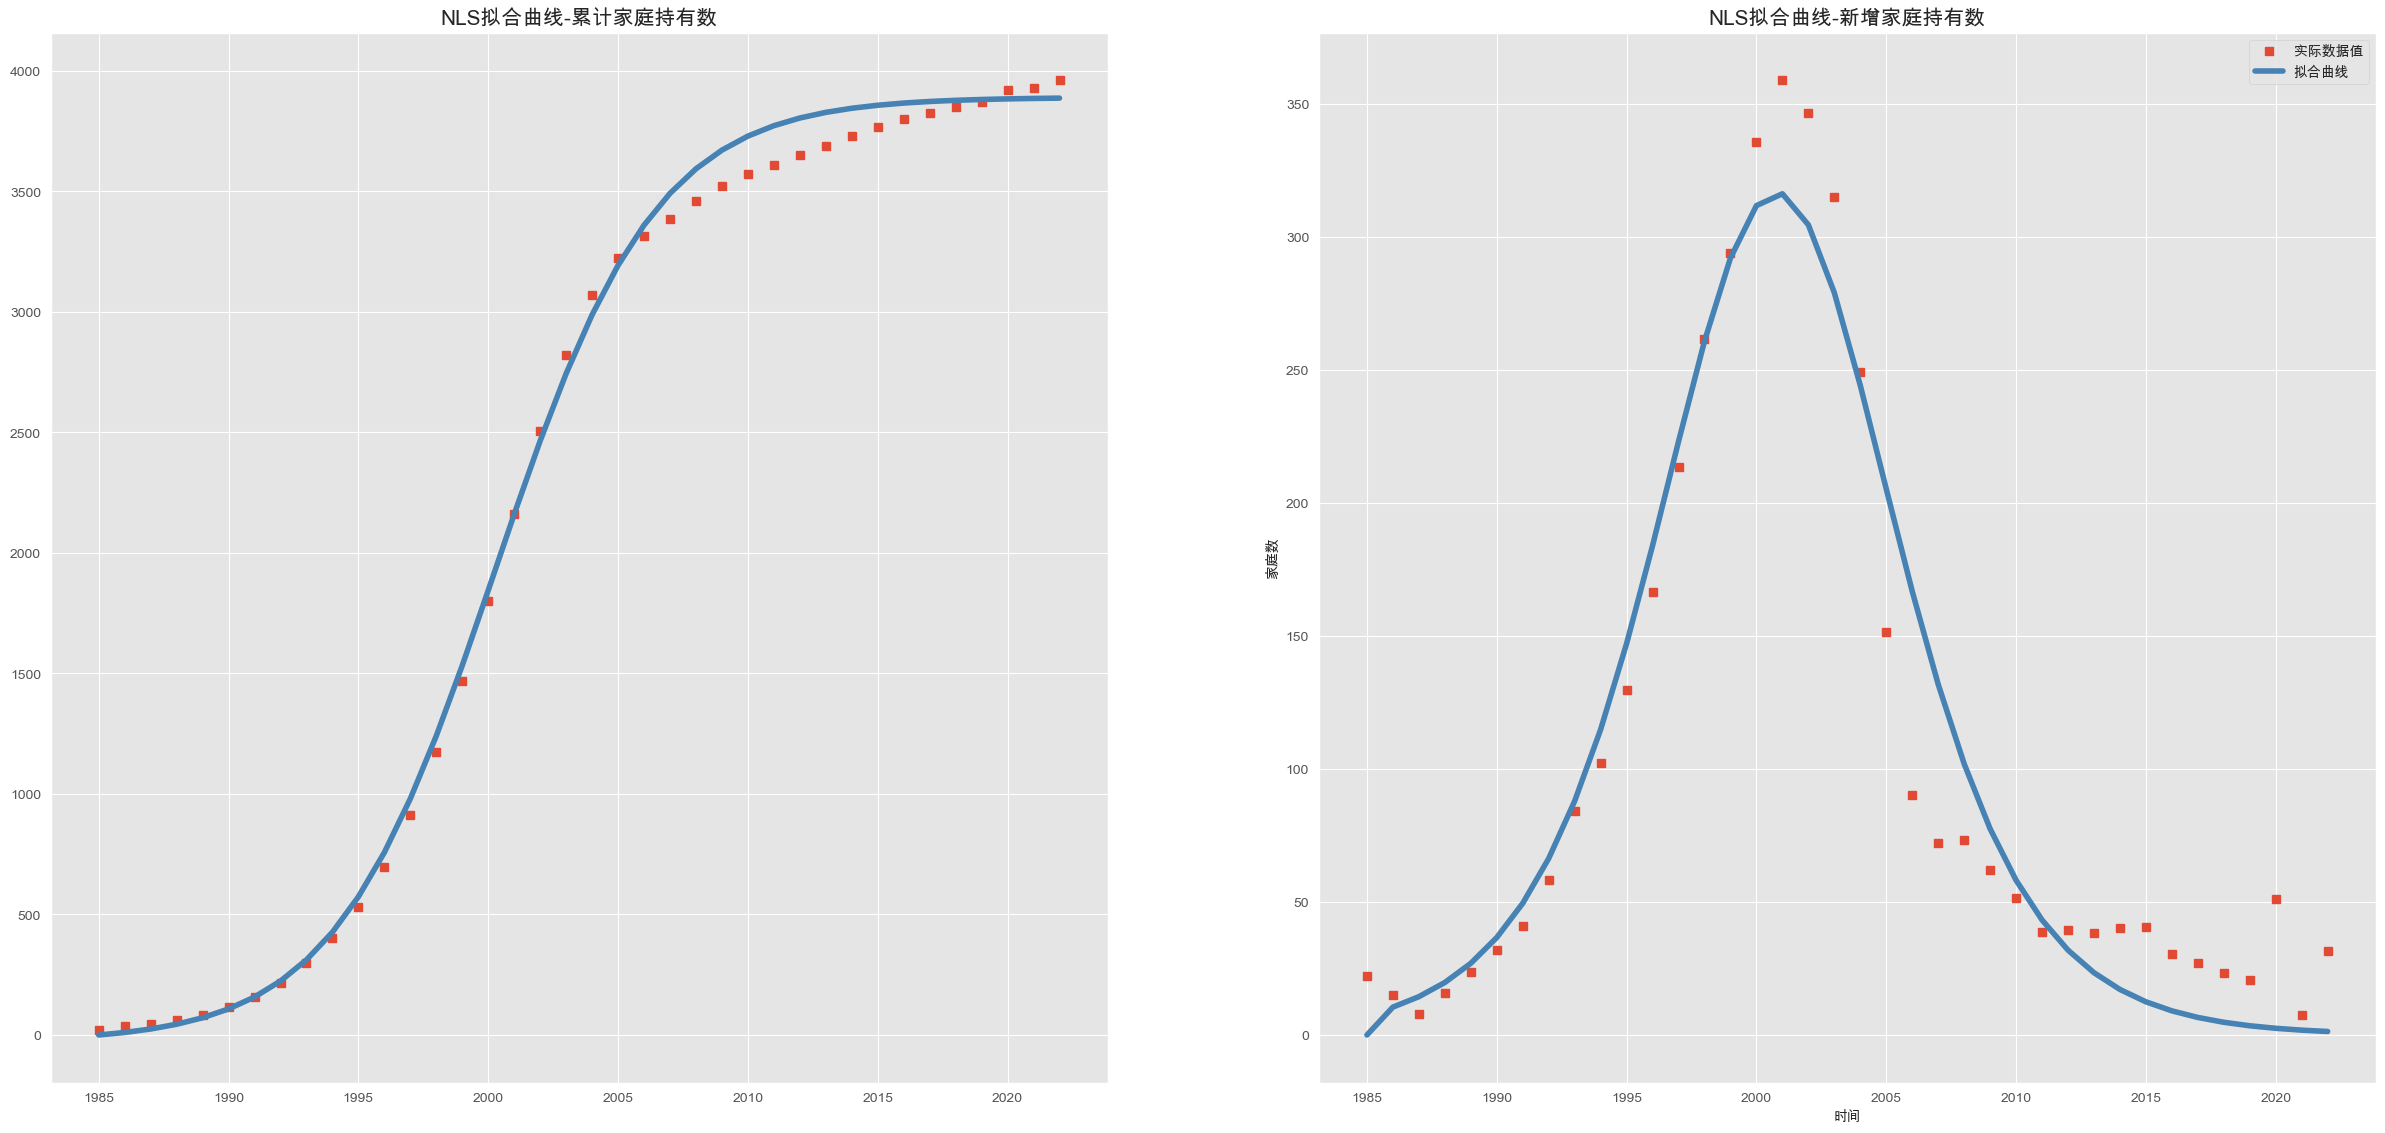

In [18]:
t = np.array([i for i in range(0, 38)])
y = df["y"]
Y = df["Y"]


def bass_model(params):
    p, q, m = params
    Y_predict = m * (1 - (np.exp(-(p + q) * t))) / (1 + q / p * np.exp(-(p + q) * t))
    residuals = Y - Y_predict
    return np.sum(residuals ** 2)


# 这些边界可能需要根据您对问题的理解来调整
bounds = [(1e-5, 1e5),  # M 的范围，例如从非常小到非常大的正数
          (1e-5, 1),  # p 的范围，一般在 0 到 1 之间
          (1e-5, 1)]  # q 的范围，一般在 0 到 1 之间

initial_params = [0.00287, 0.3323, 3890.740964]  # US
result = minimize(bass_model, initial_params, method='COBYLA')
estimated_params = result.x
p_estimated, q_estimated, m_estimated = estimated_params
# print("Estimated parameters:")
# print("p:", p_estimated)
# print("q:", q_estimated)
# print("m:", m_estimated)

T = math.log(q_estimated / p_estimated) / (p_estimated + q_estimated)
T1 = math.log((2 - 3 ** 0.5) * (q_estimated / p_estimated)) / (p_estimated + q_estimated)
T2 = math.log((2 + 3 ** 0.5) * (q_estimated / p_estimated)) / (p_estimated + q_estimated)
# print(T, T1, T2, q_estimated / p_estimated)
Y_predicted_NLS = m_estimated * (1 - (np.exp(-(p_estimated + q_estimated) * t))) / (
            1 + q_estimated / p_estimated * np.exp((-(p_estimated + q_estimated) * t)))
y_predicted_NLS = np.diff(Y_predicted_NLS, prepend=0)

fig = plt.figure(figsize=(30, 30))
plt.rcParams["font.family"] = "Arial Unicode MS"
plt.rcParams["axes.unicode_minus"] = False
plt.subplot(2, 2, 3)
plot1 = plt.plot(t + 1985, Y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, Y_predicted_NLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("NLS拟合曲线-累计家庭持有数", fontsize=15)
plt.subplot(2, 2, 4)
plot1 = plt.plot(t + 1985, y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, y_predicted_NLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("NLS拟合曲线-新增家庭持有数", fontsize=15)
plt.xlabel("时间")
plt.ylabel("家庭数")
plt.legend(loc="best")

In [19]:
# 计算 R^2（确定系数）
# evaluate_model(Y, Y_predicted_NLS)

## GA

gen	nevals
0  	200   
1  	157   
2  	171   
3  	169   
4  	161   
5  	161   
6  	156   
7  	158   
8  	150   
9  	161   
10 	159   
11 	154   
12 	149   
13 	163   
14 	149   
15 	161   
16 	168   
17 	161   
18 	169   
19 	162   
20 	171   
21 	164   
22 	165   
23 	162   
24 	154   
25 	168   
26 	159   
27 	161   
28 	159   
29 	168   
30 	159   
31 	161   
32 	156   
33 	150   
34 	151   
35 	156   
36 	155   
37 	161   
38 	155   
39 	154   
40 	152   
41 	155   
42 	160   
43 	157   
44 	159   
45 	154   
46 	150   
47 	159   
48 	156   
49 	150   
50 	164   
51 	160   
52 	148   
53 	162   
54 	159   
55 	162   
56 	162   
57 	160   
58 	157   
59 	156   
60 	172   
61 	160   
62 	155   
63 	156   
64 	170   
65 	154   
66 	164   
67 	154   
68 	152   
69 	151   
70 	147   
71 	157   
72 	153   
73 	147   
74 	158   
75 	158   
76 	159   
77 	155   
78 	162   
79 	157   
80 	155   
81 	157   
82 	153   
83 	165   
84 	155   
85 	159   
86 	151   
87 	162   
88 	157   
89 	159   

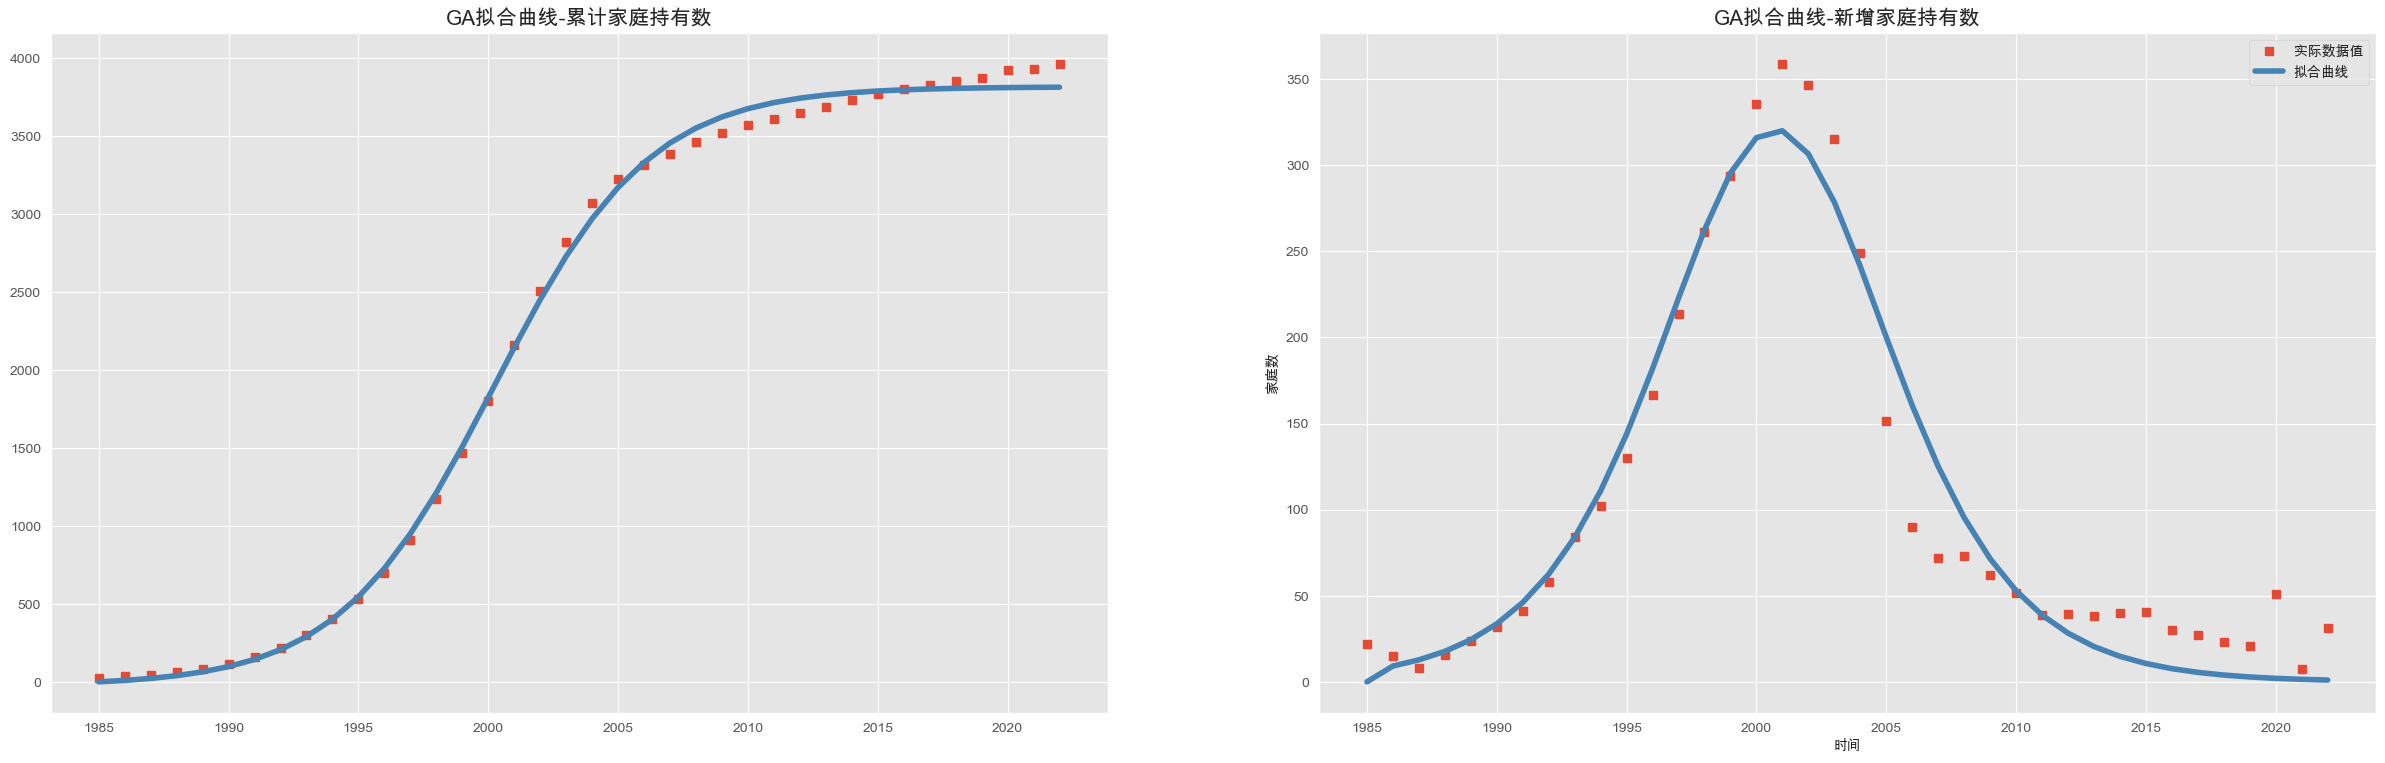

In [20]:
t = np.array([i for i in range(0, 38)])
y = df["y"]
Y = df["Y"]


def bass_model(params):
    p, q, m = params
    Y_predicted = m * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))
    residuals = Y - Y_predicted
    # 检查参数是否超出范围
    if (p < param_bounds['p'][0] or p > param_bounds['p'][1]) or (
            q < param_bounds['q'][0] or q > param_bounds['q'][1]) or (
            m < param_bounds['m'][0] or m > param_bounds['m'][1]):
        # 超出范围时的惩罚，可以是一个很大的惩罚值
        penalty = 100000
        return [np.sum(residuals ** 2) * penalty]
    # 返回一个包含残差平方和的列表
    return [np.sum(residuals ** 2)]


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

param_bounds = {
    'p': (0.0019, 0.0026),
    'q': (0.27, 0.35),
    'm': (3800, 3900)
}

def generate_param():
    p = np.random.uniform(0.0019, 0.0026)
    q = np.random.uniform(0.27, 0.35)
    m = np.random.uniform(3800, 3900)
    return [p, q, m]


toolbox.register("individual", tools.initIterate, creator.Individual, generate_param)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", bass_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
population = toolbox.population(n=200)
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.3, ngen=200, verbose=True)
best_individual = tools.selBest(population, k=1)[0]
p_estimated, q_estimated, m_estimated = best_individual

# print("p:", p_estimated)
# print("q:", q_estimated)
# print("m:", m_estimated)

# calculate_T(p_estimated, q_estimated)
Y_predicted_GA = m_estimated * (1 - np.exp(-(p_estimated + q_estimated) * t)) / (
            1 + q_estimated / p_estimated * np.exp(-(p_estimated + q_estimated) * t))
y_predicted_GA = np.diff(Y_predicted_GA, prepend=0)
# evaluate_model(Y, Y_predicted_GA)

fig = plt.figure(figsize=(30, 30))
plt.rcParams["font.family"] = "Arial Unicode MS"
plt.rcParams["axes.unicode_minus"] = False

plt.subplot(3, 2, 1)
plot1 = plt.plot(t + 1985, Y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, Y_predicted_GA, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("GA拟合曲线-累计家庭持有数", fontsize=15)
plt.subplot(3, 2, 2)
plot1 = plt.plot(t + 1985, y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, y_predicted_GA, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("GA拟合曲线-新增家庭持有数", fontsize=15)
plt.xlabel("时间")
plt.ylabel("家庭数")
plt.legend(loc="best")

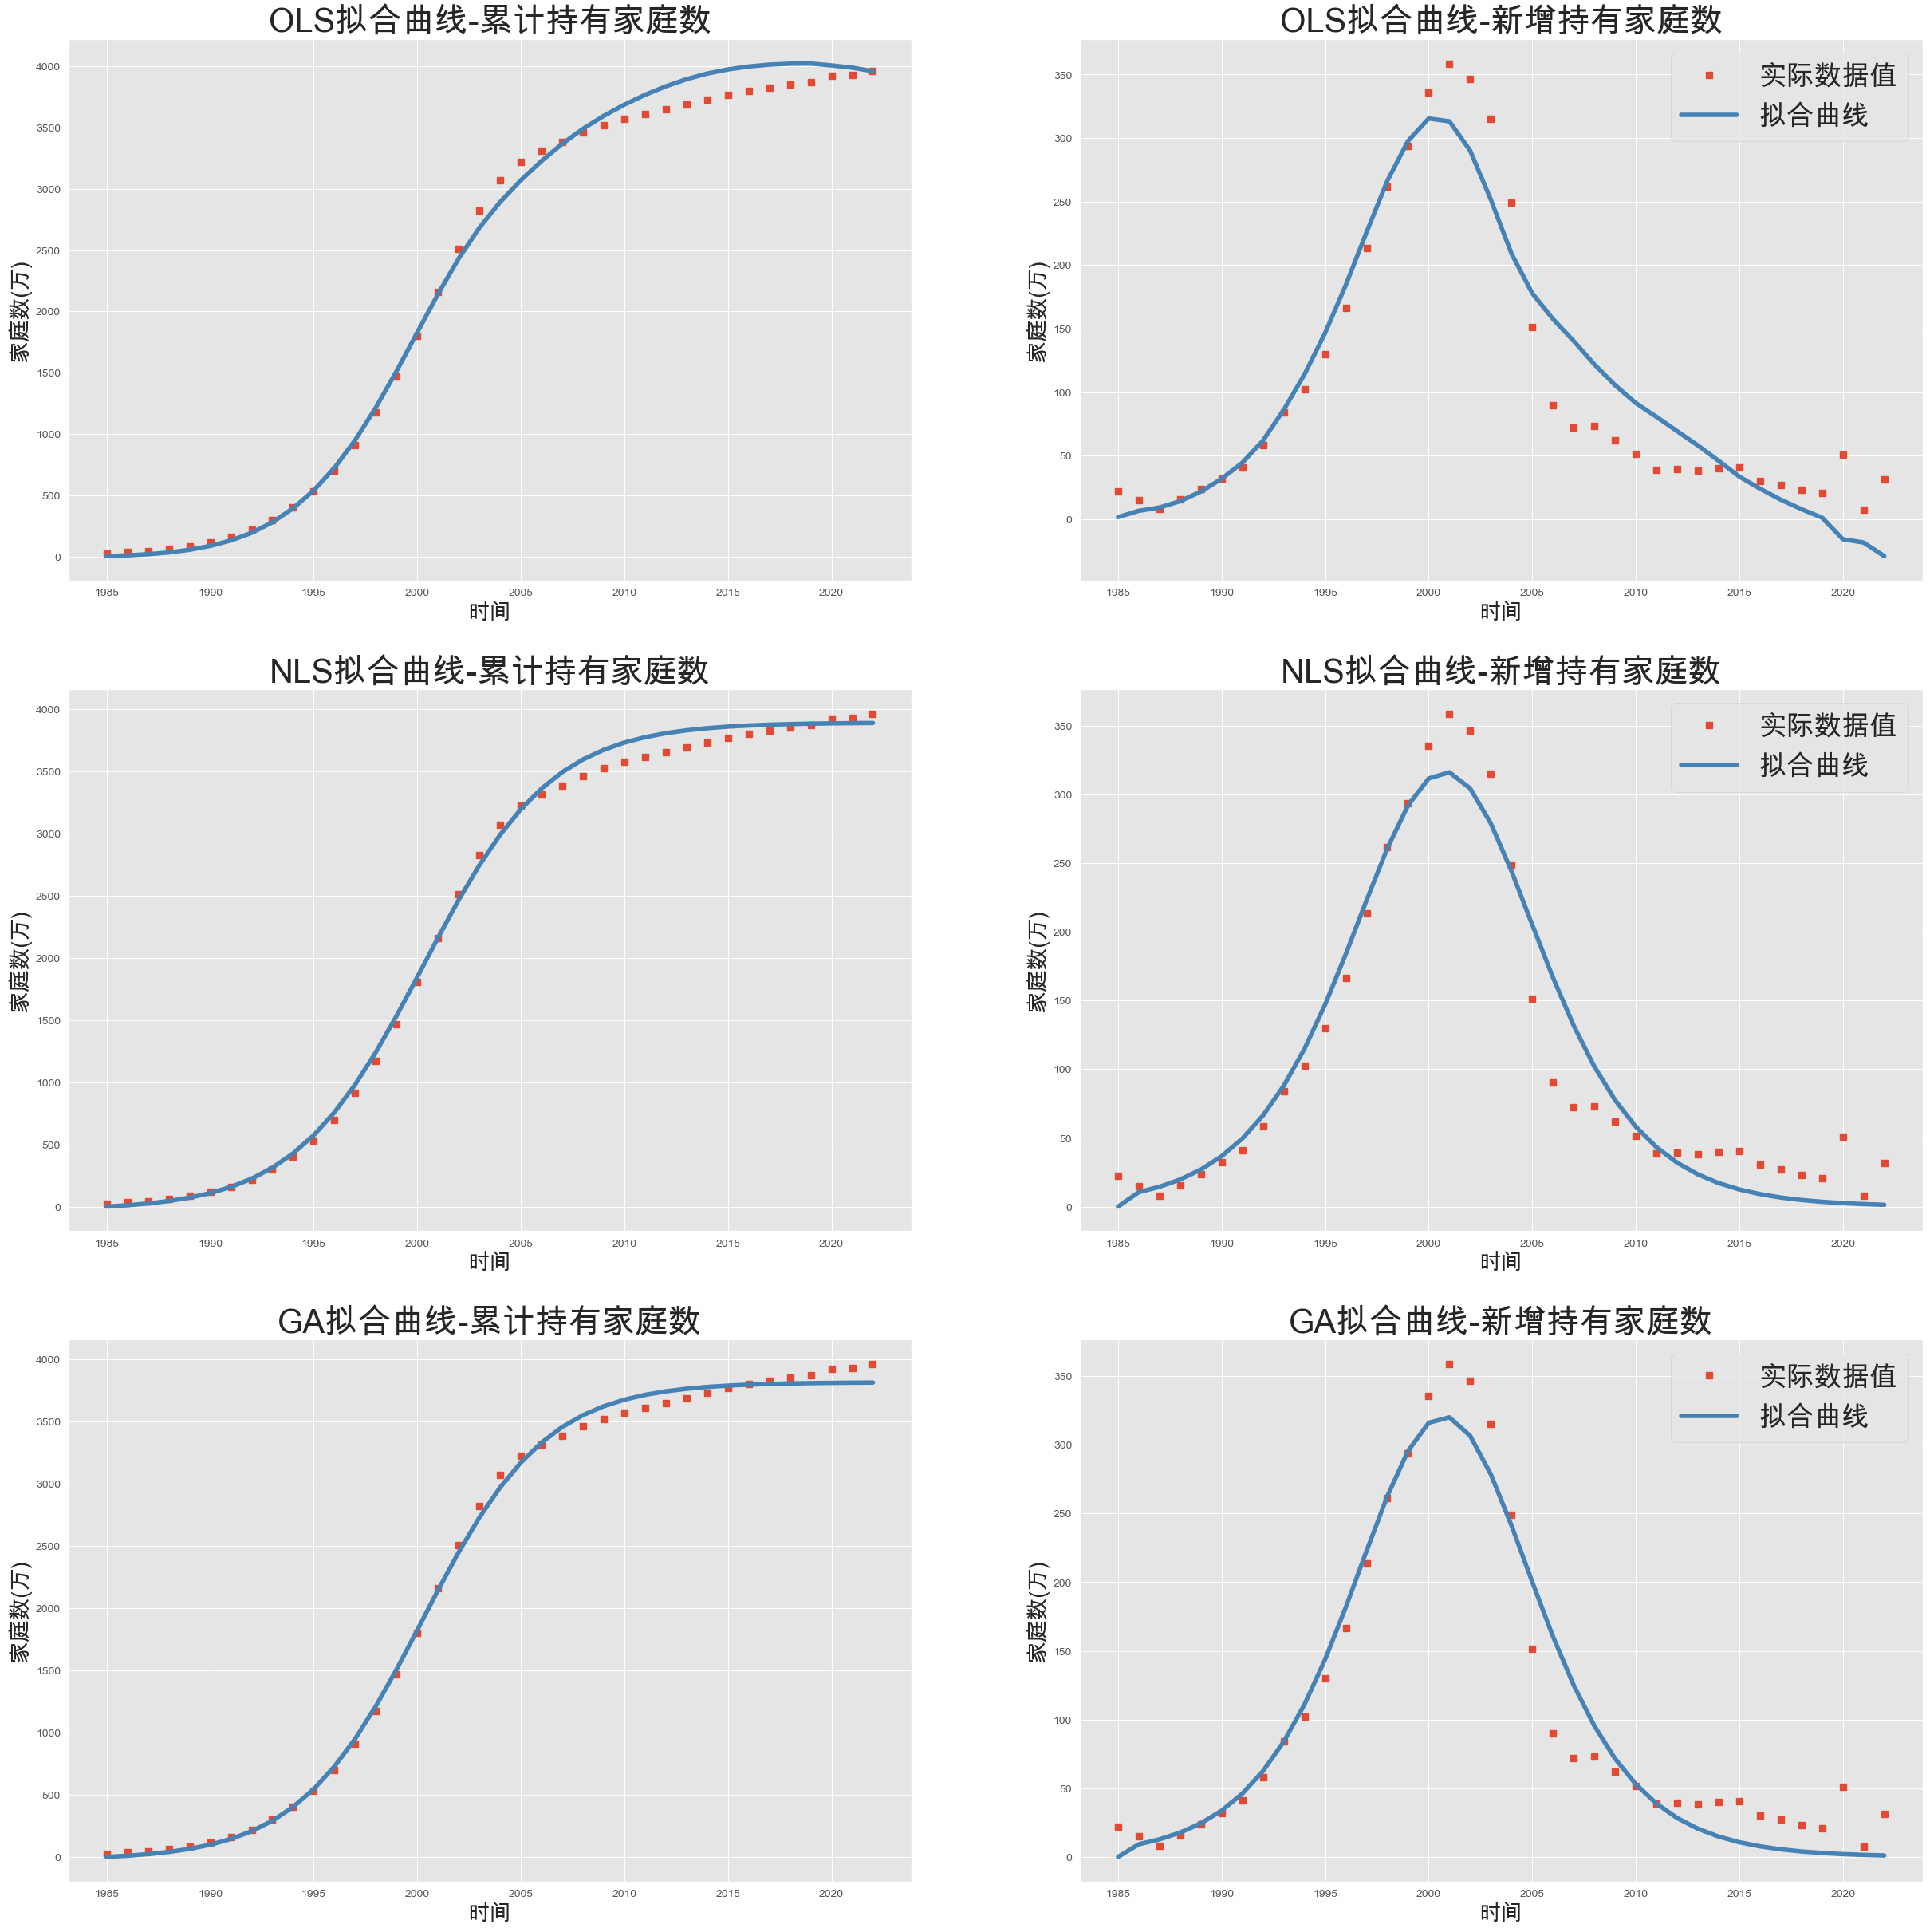

In [21]:
# 统一图像
fig = plt.figure(figsize=(30, 30))
plt.rcParams["font.family"] = "Arial Unicode MS"
plt.rcParams["axes.unicode_minus"] = False
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)  # 设置坐标标签字体大小

plt.subplot(3, 2, 1)
plot1 = plt.plot(t + 1985, Y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, Y_predicted_OLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("OLS拟合曲线-累计持有家庭数", fontsize=30)
plt.xlabel("时间", fontsize=20)
plt.ylabel("家庭数(万)", fontsize=20)
plt.subplot(3, 2, 2)
plot1 = plt.plot(t + 1985, y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, y_predicted_OLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.xlabel("时间", fontsize=20)
plt.ylabel("家庭数(万)", fontsize=20)
plt.title("OLS拟合曲线-新增持有家庭数", fontsize=30)
plt.legend(loc="best", prop={'size': 25})

plt.subplot(3, 2, 3)
plot1 = plt.plot(t + 1985, Y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, Y_predicted_NLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("NLS拟合曲线-累计持有家庭数", fontsize=30)
plt.xlabel("时间", fontsize=20)
plt.ylabel("家庭数(万)", fontsize=20)
plt.subplot(3, 2, 4)
plot1 = plt.plot(t + 1985, y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, y_predicted_NLS, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("NLS拟合曲线-新增持有家庭数", fontsize=30)
plt.xlabel("时间", fontsize=20)
plt.ylabel("家庭数(万)", fontsize=20)
plt.legend(loc="best", prop={'size': 25})

plt.subplot(3, 2, 5)
plot1 = plt.plot(t + 1985, Y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, Y_predicted_GA, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("GA拟合曲线-累计持有家庭数", fontsize=30)
plt.xlabel("时间", fontsize=20)
plt.ylabel("家庭数(万)", fontsize=20)
plt.subplot(3, 2, 6)
plot1 = plt.plot(t + 1985, y, "s", linewidth=5, label="实际数据值")
plot2 = plt.plot(t + 1985, y_predicted_GA, "r", c="steelblue", linewidth=4, label="拟合曲线")
plt.title("GA拟合曲线-新增持有家庭数", fontsize=30)
plt.xlabel("时间", fontsize=20)
plt.ylabel("家庭数(万)", fontsize=20)
plt.legend(loc="best", prop={'size': 25})
fig.savefig("./result.jpg", dpi=300)

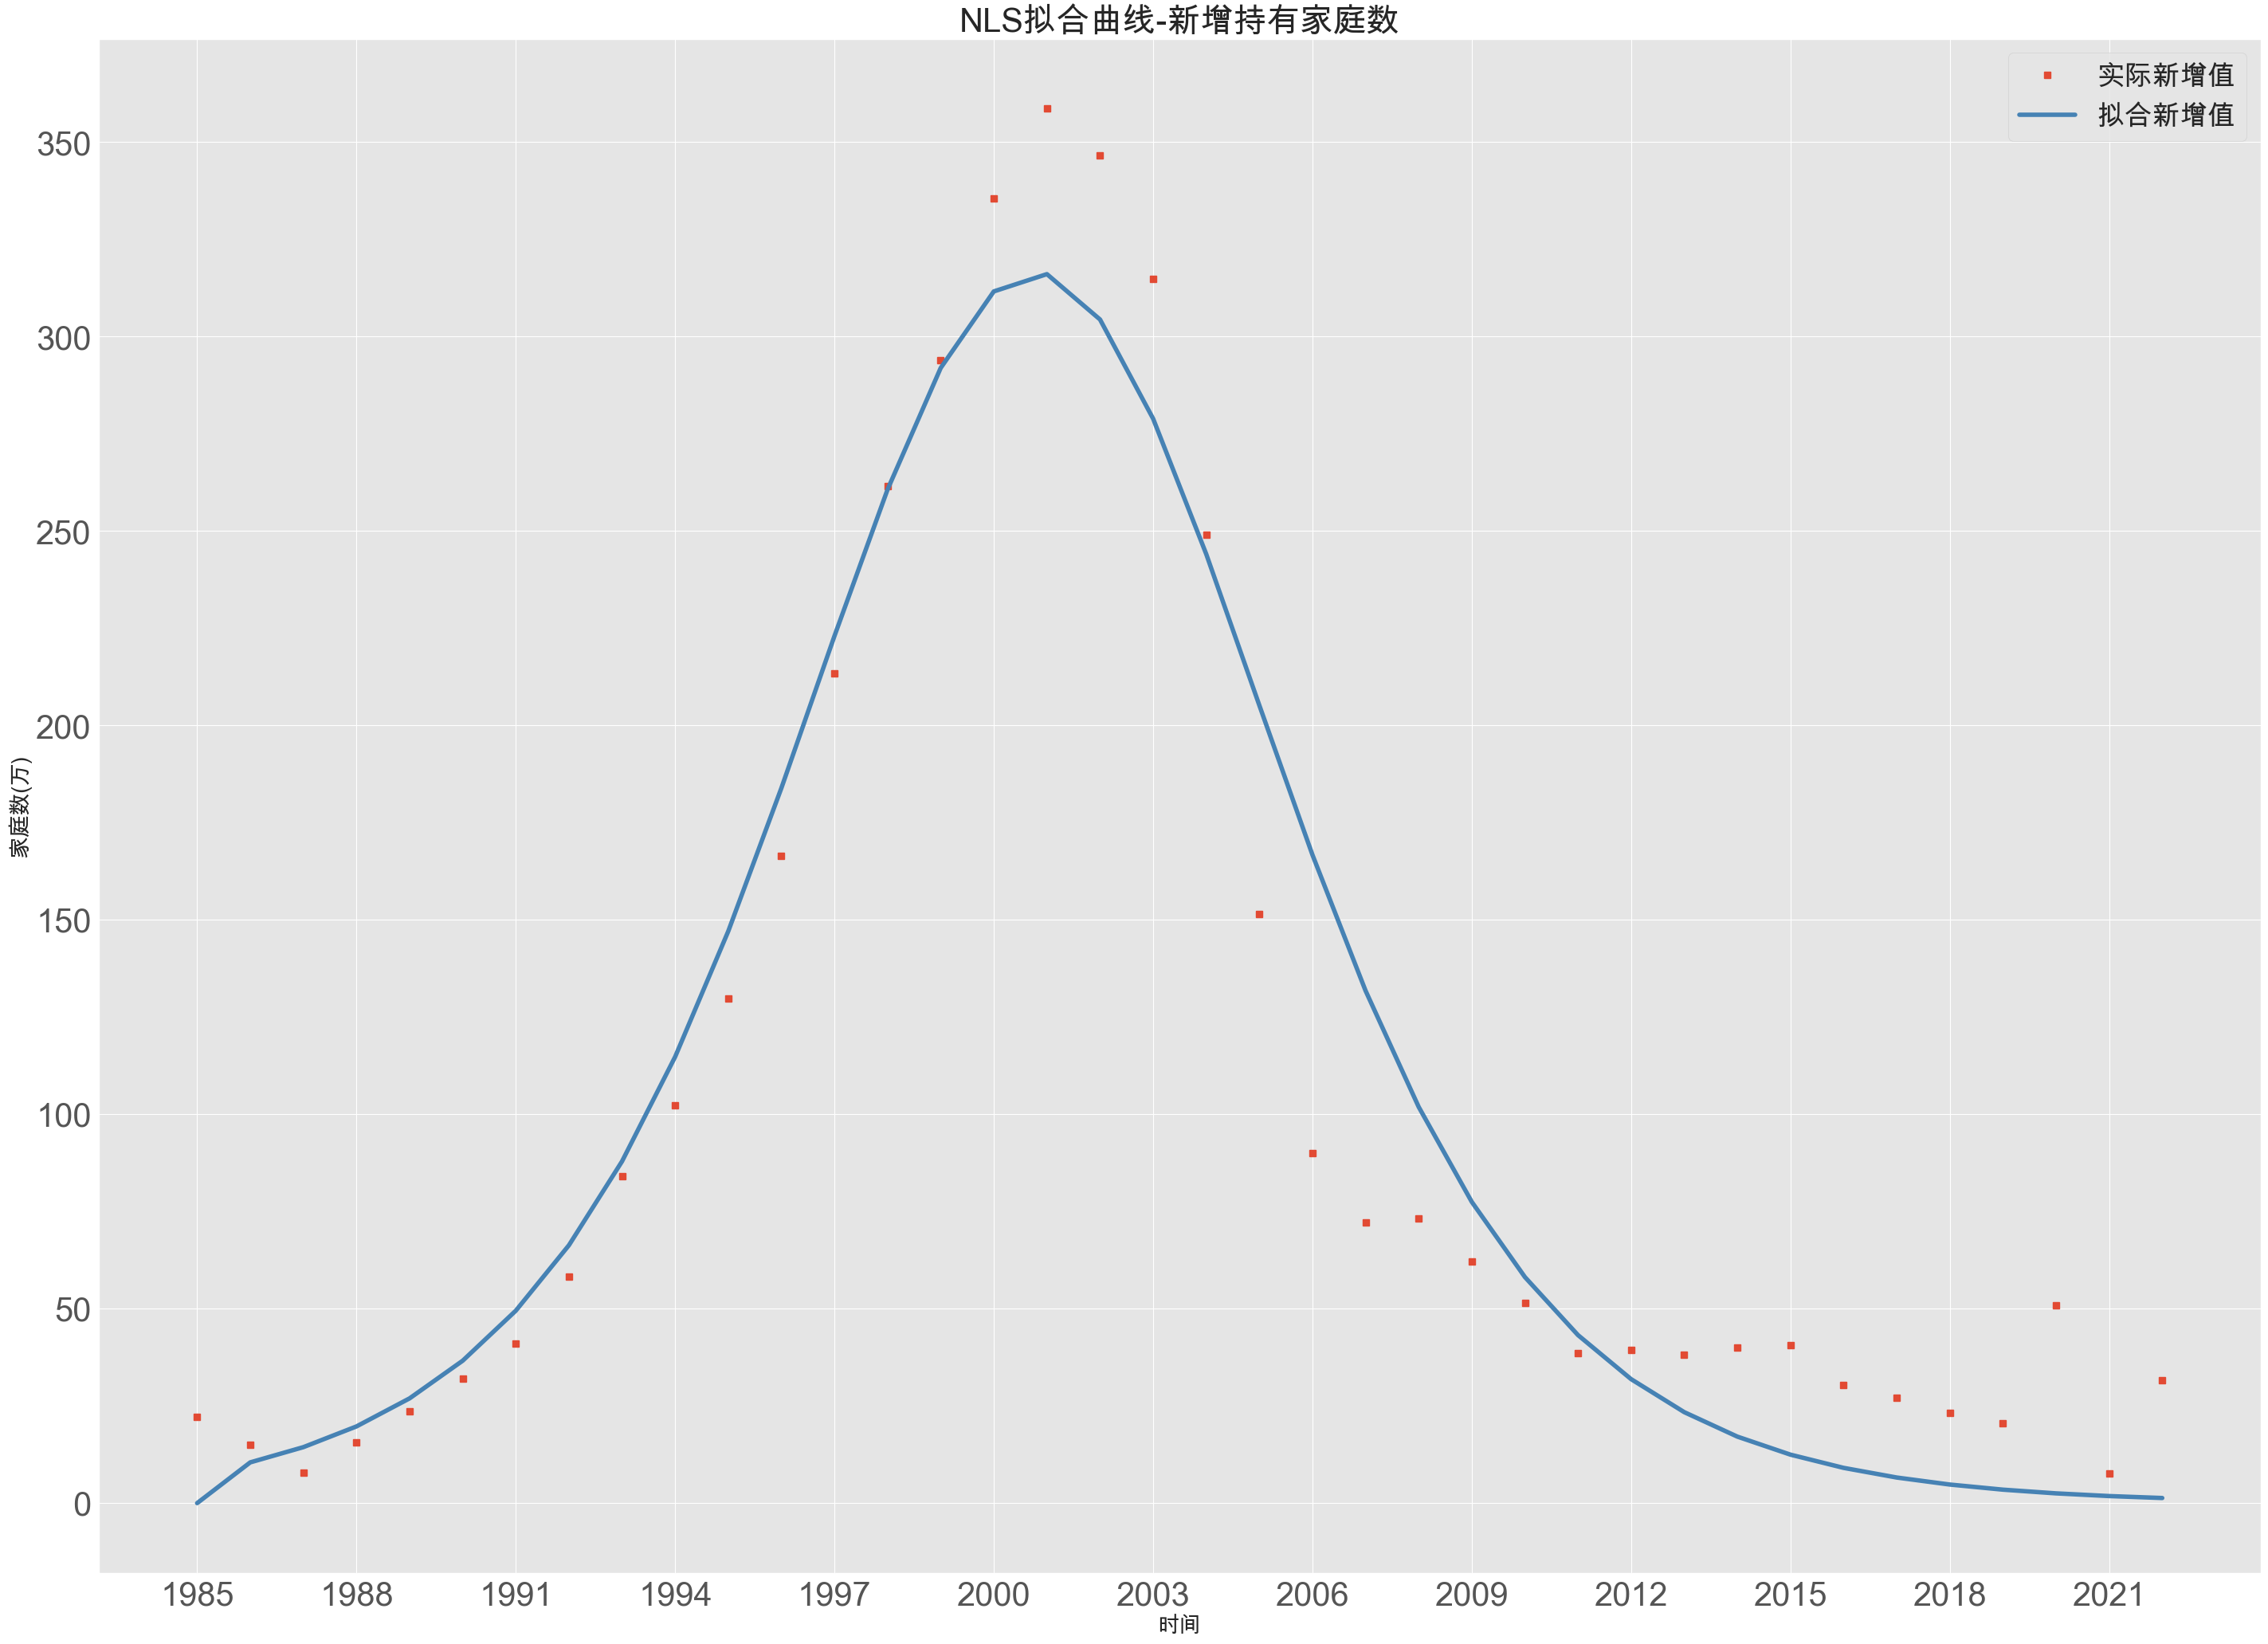

In [22]:
fig = plt.figure(figsize=(35, 25))
plt.rcParams["font.family"] = "Arial Unicode MS"
plt.rcParams["axes.unicode_minus"] = False
my_x_ticks = np.arange(1985, 2025, 3)
plt.xticks(my_x_ticks)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)  # 设置坐标标签字体大小

# plot1=plt.plot(t+1985, Y, "s", linewidth=5, label="实际累计值")
# plot2=plt.plot(t+1985,Y_predicted_NLS,"r",c="steelblue",linewidth=4,label="拟合累计值（万人）")
plot3 = plt.plot(t + 1985, y, "s", linewidth=5, label="实际新增值")
plot4 = plt.plot(t + 1985, y_predicted_NLS, "r", c="steelblue", linewidth=4, label="拟合新增值")
plt.title("NLS拟合曲线-累计持有家庭数", fontsize=30)
plt.xlabel("时间", fontsize=20)
plt.ylabel("家庭数(万)", fontsize=20)

plt.title("NLS拟合曲线-新增持有家庭数", fontsize=30)

plt.legend(loc="best", prop={'size': 25})
fig.savefig("./new_households.jpeg", dpi=300)